# devlog 2024-03-01

CompartmentModel methods for querying the indices of compartments and events.

## Motivation

Complex models like the COVID-19 model developed for SPARSEMOD can increase the descriptive power of the simulation, but the complexity poses challenges in interpreting the results. epymorph now includes a few utilities for common results processing tasks.

Let's run an example:

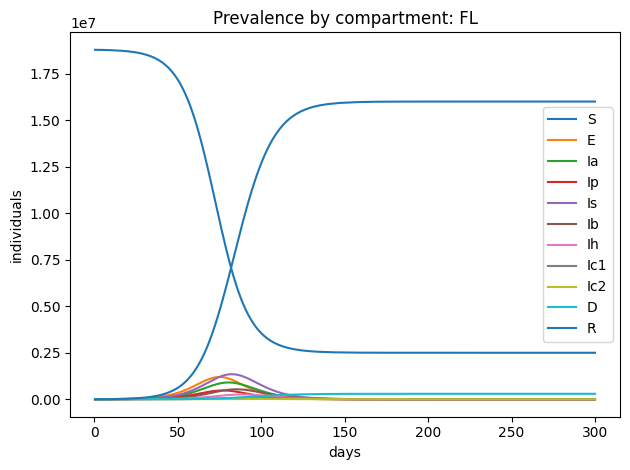

In [7]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from epymorph import *
from epymorph.initializer import single_location

ipm = ipm_library["sparsemod"]()

sim = StandardSimulation(
    geo=geo_library["pei"](),
    ipm=ipm,
    mm=mm_library["centroids"](),
    params={
        # IPM params
        "beta": 0.3,
        "omega": [0.55, 0.05],
        "delta": [0.333, 0.5, 0.166, 0.142, 0.125],
        "gamma": [0.166, 0.333, 0.25],
        "rho": [0.4, 0.175, 0.015, 0.2, 0.6],
        # movement model params
        "phi": 40.0,
    },
    time_frame=TimeFrame.of("2015-01-01", 300),
    initializer=partial(single_location, location=0, seed_size=10_000),
    rng=default_rng(10108),
)

out = sim.run()

plot_pop(out, 0)

Here we see all of the compartments over time. This is a good start, but because we have multiple stages of infection, we can't really appreciate how many people are currently infectious compared to the other classes. We need to compute a sum across our compartments of interest (in this case, any compartment starting with "I").

These sort of data manipulation tasks were always possible, however since our output is a numpy array we must know the array indices of the data we're interested in to do it successfully.

Previously, one had to visually inspect the list of compartments or events:

In [8]:
display(ipm.compartment_names)
display(ipm.event_names)

['S', 'E', 'Ia', 'Ip', 'Is', 'Ib', 'Ih', 'Ic1', 'Ic2', 'D', 'R']

['S → E',
 'E → Ia',
 'E → Ip',
 'Ip → Is',
 'Is → Ih',
 'Is → Ic1',
 'Is → Ib',
 'Ih → Ic1',
 'Ih → R',
 'Ic1 → D',
 'Ic1 → Ic2',
 'Ia → R',
 'Ib → R',
 'Ic2 → R']

Okay, so the infectious indices are: 2, 3, 4, 5, 6, 7, 8; with 0, 1, 9, and 10 being non-infectious. Now I can sum and plot.

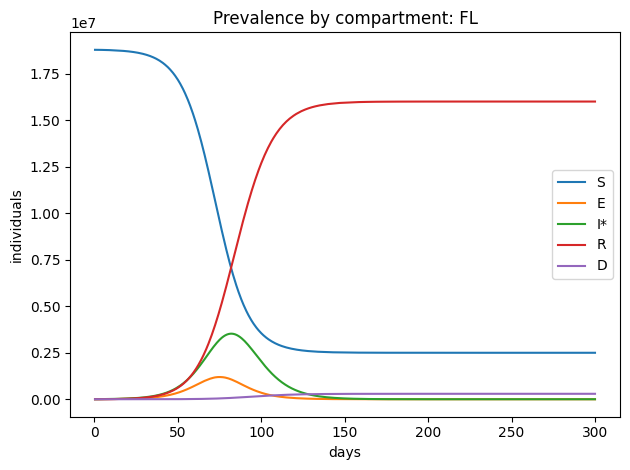

In [9]:
fig, ax = plt.subplots()
ax.set_title(f"Prevalence by compartment: {out.geo_labels[0]}")
ax.set_xlabel("days")
ax.set_ylabel("individuals")
x_axis = out.ticks_in_days
ax.plot(x_axis, out.prevalence[:, 0, 0], label="S")
ax.plot(x_axis, out.prevalence[:, 0, 1], label="E")
ax.plot(x_axis, out.prevalence[:, 0, (2, 3, 4, 5, 6, 7, 8)].sum(axis=1), label="I*")
ax.plot(x_axis, out.prevalence[:, 0, 10], label="R")
ax.plot(x_axis, out.prevalence[:, 0, 9], label="D")
ax.legend()
fig.tight_layout()
plt.show()

That works, but managing a bunch of indices by hand is error prone and not very descriptive. With epymorph's new features, we can do this in a more declarative fashion. Instead of hard-coding indices, we can use `ipm.compartments_by()` to retrieve indices for us. Notice I can use an asterisk as a wildcard.

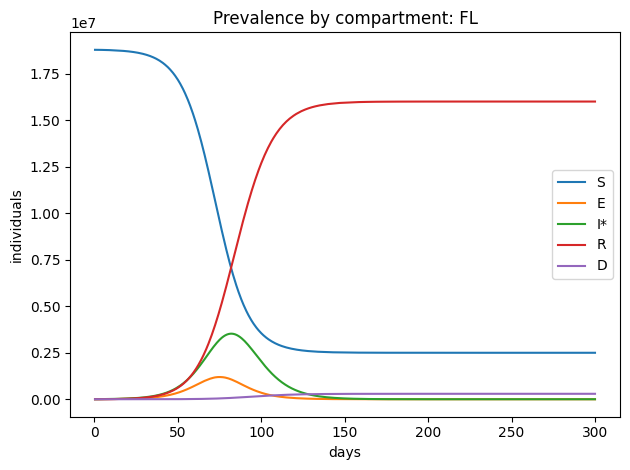

In [10]:
fig, ax = plt.subplots()
ax.set_title(f"Prevalence by compartment: {out.geo_labels[0]}")
ax.set_xlabel("days")
ax.set_ylabel("individuals")
x_axis = out.ticks_in_days
ax.plot(x_axis, out.prevalence[:, 0, ipm.compartments_by("S")], label="S")
ax.plot(x_axis, out.prevalence[:, 0, ipm.compartments_by("E")], label="E")
ax.plot(x_axis, out.prevalence[:, 0, ipm.compartments_by("I*")].sum(axis=1), label="I*")
ax.plot(x_axis, out.prevalence[:, 0, ipm.compartments_by("R")], label="R")
ax.plot(x_axis, out.prevalence[:, 0, ipm.compartments_by("D")], label="D")
ax.legend()
fig.tight_layout()
plt.show()

There is also `ipm.events_by_src()` and `ipm.events_by_dst()`. Say we're interested in how many people are recovering every day. There are multiple paths to recovery! (Events 8, 11, 12, and 13.) We'll need to aggregate them before we can plot.

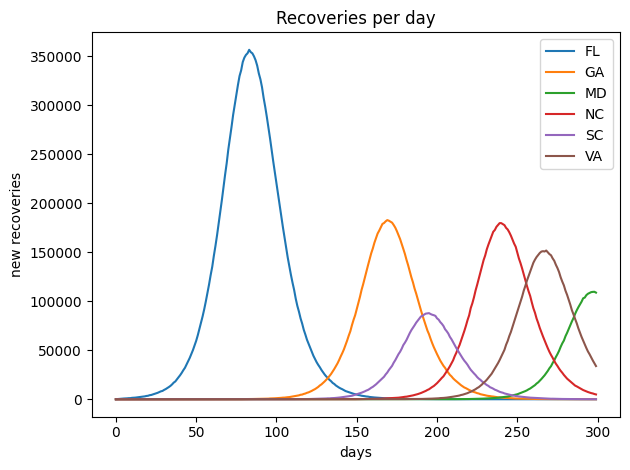

In [12]:
fig, ax = plt.subplots()
ax.set_title("Recoveries per day")
ax.set_xlabel("days")
ax.set_ylabel("new recoveries")
ax.plot(
    np.arange(out.dim.days),
    out.incidence_per_day[:, :, ipm.events_by_dst("R")].sum(axis=2),
    label=out.geo_labels,
)
ax.legend()
fig.tight_layout()
plt.show()